In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
from pathlib import Path
import numpy as np 
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array

In [2]:
input_dir  = Path('input')
train = input_dir / 'train'
train_cleaned = input_dir / 'train_cleaned'
test = input_dir / 'test'

Total number of images in the training set:  964
Total number of cleaned images found:  690
Total number of samples in the test set:  148


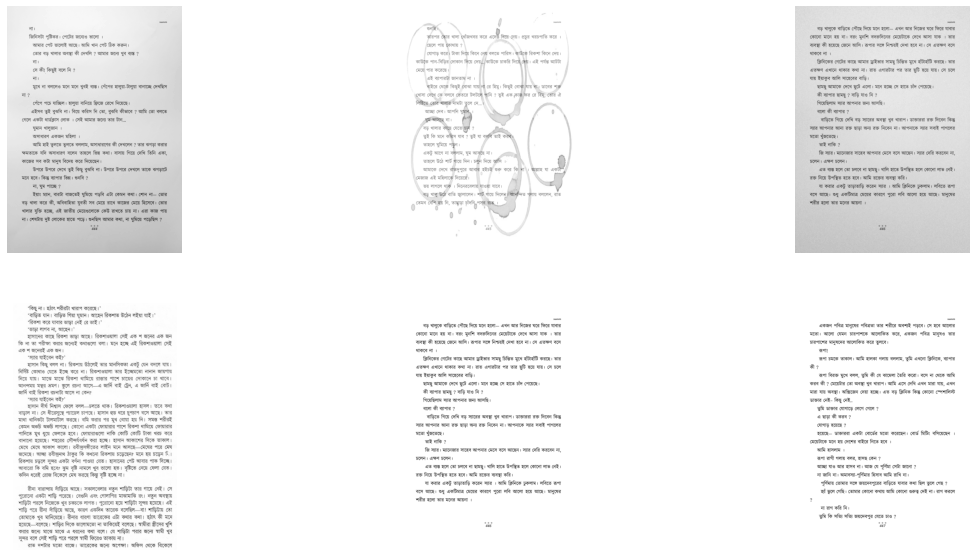

In [4]:
train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

samples = train_images[:3] + train_labels[:3]

f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    if i>2:
        img = imread(train_cleaned/img)
    else:
        img = imread(train/img)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show() 


In [5]:
X = []
Y = []

for img in train_images:
    img = load_img(train / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

Size of X :  (964, 420, 540, 1)
Size of Y :  (690, 420, 540, 1)


In [7]:
X=X.reshape((964,420,540))
Y=Y.reshape((690,420,540))
print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

Size of X :  (964, 420, 540)
Size of Y :  (690, 420, 540)


In [8]:
#create patch of size 28*30 
#total no of patch from one image=270
def patch(x):
    xd=[]
    for i in range(0,393,28):
        for j in range(0,511,30):
            xd.append(x[i:i+28,j:j+30])
    xd=np.array(xd)
    return xd

def patch_restore(b):
    
    res=np.empty((0,540), np.float32)
    cur=b[0]
    for i in range(1,270):
        if i%18==0:
            res=np.append(res,cur,axis=0)
            cur=b[i]
        else:
            cur=np.append(cur,b[i],axis=1)
    res=np.append(res,cur,axis=0)
    return res  

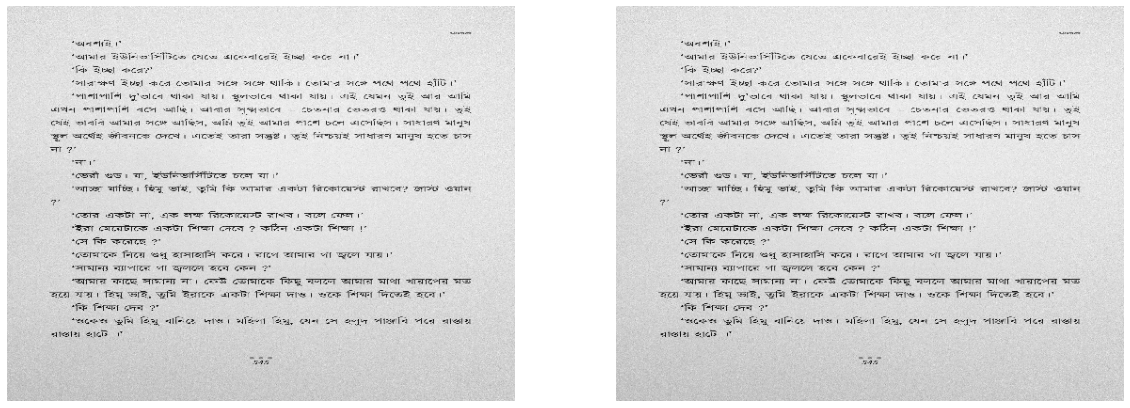

In [9]:
f, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(X[72], cmap='gray')
ax[0].axis('off')
#crete patch and restore back to its original form
s=patch(X[72])
p=patch_restore(s)
ax[1].imshow(p, cmap='gray')
ax[1].axis('off')
plt.show() 

In [10]:
Xd=patch(X[0])
for i in range(1,144):
    Xd=np.append(Xd,patch(X[i]),axis=0)

Yd=patch(Y[0])
for i in range(1,144):
    Yd=np.append(Yd,patch(Y[i]),axis=0)

print("Size of Xd : ", Xd.shape)
print("Size of Yd : ", Yd.shape)

Size of Xd :  (38880, 28, 30)
Size of Yd :  (38880, 28, 30)


In [11]:
Xd=Xd.reshape((38880,28,30,1))
Yd=Yd.reshape((38880,28,30,1))
print("Size of Xd : ", Xd.shape)
print("Size of Yd : ", Yd.shape)

Size of Xd :  (38880, 28, 30, 1)
Size of Yd :  (38880, 28, 30, 1)


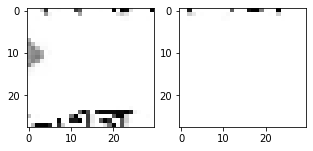

In [12]:
f, ax = plt.subplots(1, 2, figsize=(5,5))
ax[0].imshow(Xd[5000].reshape((28,30)),cmap='gray')
ax[0].axis('on')
ax[1].imshow(Yd[5000].reshape((28,30)),cmap='gray')
ax[1].axis('on')
plt.show() 

In [14]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Archi\Anaconda3\envs\test-tf\python.exe -m pip install --upgrade pip' command.


In [15]:
# Split the dataset into training and validation.
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(Xd, Yd, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (34992, 28, 30, 1)
Total number of validation samples:  (3888, 28, 30, 1)


In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input,Conv3D
from keras.optimizers import SGD, Adam, Adadelta, Adagrad


def build_autoenocder():
    input_img = Input(shape=(28,30,1), name='image_input')
    
    x = Conv2D(64, (3,3), activation='relu', padding='same',name='Conv1')(input_img)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = Conv2D(16, (4,4), activation='relu', padding='same', name='Conv4')(x)
    x = Conv2D(1, (4,4), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

autoencoder = build_autoenocder()
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 28, 30, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 28, 30, 64)        640       
_________________________________________________________________
Conv2 (Conv2D)               (None, 28, 30, 32)        18464     
_________________________________________________________________
Conv3 (Conv2D)               (None, 28, 30, 32)        9248      
_________________________________________________________________
Conv4 (Conv2D)               (None, 28, 30, 16)        8208      
_________________________________________________________________
Conv5 (Conv2D)               (None, 28, 30, 1)         257       
Total params: 36,817
Trainable params: 36,817
Non-trainable params: 0
_________________________________________________________

In [17]:
autoencoder.fit(X_train, y_train, epochs=10, batch_size=512, validation_data=(X_valid, y_valid))

Epoch 1/10
69/69 [==============================] - 192s 3s/step - loss: 0.3329 - val_loss: 0.2071
Epoch 2/10
69/69 [==============================] - 190s 3s/step - loss: 0.2041 - val_loss: 0.1981
Epoch 3/10
69/69 [==============================] - 192s 3s/step - loss: 0.1989 - val_loss: 0.1944
Epoch 4/10
69/69 [==============================] - 191s 3s/step - loss: 0.1964 - val_loss: 0.1937
Epoch 5/10
69/69 [==============================] - 212s 3s/step - loss: 0.1952 - val_loss: 0.1930
Epoch 6/10
69/69 [==============================] - 205s 3s/step - loss: 0.1941 - val_loss: 0.1928
Epoch 7/10
69/69 [==============================] - 189s 3s/step - loss: 0.1938 - val_loss: 0.1922
Epoch 8/10
69/69 [==============================] - 191s 3s/step - loss: 0.1932 - val_loss: 0.1920
Epoch 9/10
69/69 [==============================] - 187s 3s/step - loss: 0.1918 - val_loss: 0.1918
Epoch 10/10
69/69 [==============================] - 187s 3s/step - loss: 0.1924 - val_loss: 0.1919


In [18]:
autoencoder.save('autoencoder1binary.h5')

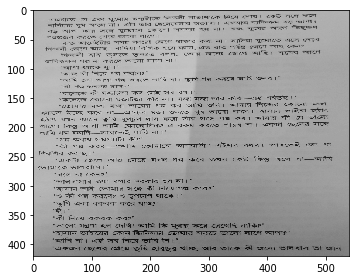

In [19]:
testin = load_img(test/ test_images[63], grayscale=True, target_size=(420,540))
testin = img_to_array(testin).astype('float32')/255
testin=testin.reshape((420,540))
imshow(testin)

In [20]:
testpatch=patch(testin)
p=np.expand_dims(testpatch, axis=3)
print('shape of patch ',p.shape)
pred=autoencoder.predict(p)
print(pred.shape)
pred=np.squeeze(pred)
print(pred.shape)
pred=patch_restore(pred)
print(pred.shape)

shape of patch  (270, 28, 30, 1)
(270, 28, 30, 1)
(270, 28, 30)
(420, 540)


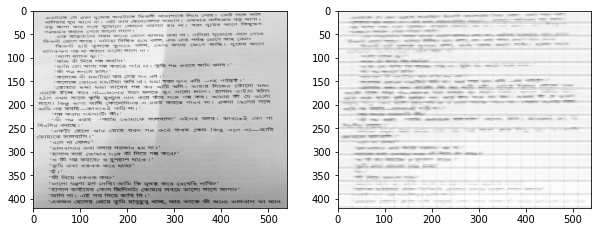

In [21]:
f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(testin, cmap='gray')
ax[1].imshow(pred, cmap='gray')
plt.show()

In [24]:
from matplotlib import image
image.imsave('autoencoder3.png',pred,cmap='gray')
k=test_images.index('noise_image_correct.jpg')
k

141

In [25]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input,Conv3D
from keras.optimizers import SGD, Adam, Adadelta, Adagrad

def build_autoenocder1():
    input_img = Input(shape=(28,30,1), name='image_input')
    
    x = Conv2D(64, (3,3), activation='relu', padding='same',name='Conv1')(input_img)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = Conv2D(16, (4,4), activation='relu', padding='same', name='Conv4')(x)
    x = Conv2D(1, (4,4), activation='relu', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

autoencoderrelu = build_autoenocder1()
autoencoderrelu.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 28, 30, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 28, 30, 64)        640       
_________________________________________________________________
Conv2 (Conv2D)               (None, 28, 30, 32)        18464     
_________________________________________________________________
Conv3 (Conv2D)               (None, 28, 30, 32)        9248      
_________________________________________________________________
Conv4 (Conv2D)               (None, 28, 30, 16)        8208      
_________________________________________________________________
Conv5 (Conv2D)               (None, 28, 30, 1)         257       
Total params: 36,817
Trainable params: 36,817
Non-trainable params: 0
_______________________________________________________

In [ ]:
autoencoderrelu.fit(X_train, y_train, epochs=10, batch_size=512, validation_data=(X_valid, y_valid))

Epoch 1/10
69/69 [==============================] - 193s 3s/step - loss: 0.8571 - val_loss: 0.3296
Epoch 2/10
69/69 [==============================] - 211s 3s/step - loss: 0.3958 - val_loss: 0.2819
Epoch 3/10
69/69 [==============================] - 218s 3s/step - loss: 0.3033 - val_loss: 0.3606
Epoch 4/10
69/69 [==============================] - 256s 4s/step - loss: 0.3077 - val_loss: 0.3019
Epoch 5/10
69/69 [==============================] - 247s 4s/step - loss: 0.2733 - val_loss: 0.2353
Epoch 6/10
69/69 [==============================] - 1601s 23s/step - loss: 0.2502 - val_loss: 0.2369 - ETA: 7:11 - loss: - ETA: 8:18 - l
Epoch 7/10
62/69 [=========================>....] - ETA: 1:09 - loss: 0.2434

In [ ]:
autoencoderrelu.save('model/autoencoder1relu.h5')